# Desarrollo Tarea 4

#### **Estudiantes:** 
* Omar David Toledo Leguizamón (202424446)

Antes de entrar a los problemas de grafos, vamos a diseñar un conjunto de rutinas que nos permitirán visualizar los grafos

In [3]:
!pip -q install networkx numpy matplotlib

In [4]:
import networkx as nx  # Librería para manejar grafos
import matplotlib.pyplot as plt  # Librería para graficar

import numpy as np

def check_matrices_identical(file1, file2):
    """
    Loads two matrices from text files and checks if they are identical.

    Parameters:
        file1 (str): The name of the first file.
        file2 (str): The name of the second file.

    Returns:
        bool: True if the matrices are identical, False otherwise.
    """
    def load_matrix(filename):
        """Helper function to load a matrix from a file."""
        return np.loadtxt(filename, delimiter='\t')

    # Load both matrices
    matrix1 = load_matrix(file1)
    matrix2 = load_matrix(file2)

    if not np.array_equal(matrix1, matrix2):
        print("Matrices are different. Locations of differences:")
    else:
        print('Matrices are equal')
    
    # Create a boolean array that is True where elements differ
    differences = matrix1 != matrix2
    
    # Get the indices of the differing elements
    differing_indices = np.argwhere(differences)

    for index in differing_indices:
        row, col = index
        print(f"Difference at (row {row}, column {col}): {matrix1[row, col]} != {matrix2[row, col]}")

def drawBooksProblem(sets, edges_with_weights, figsize=(10, 6), maxFlow=None):
    """
    Dibuja un grafo dirigido con conjuntos de nodos dispuestos verticalmente.

    Parámetros:
    - sets: Lista de listas, donde cada lista es un conjunto de etiquetas de nodos.
    - edges_with_weights: Lista de tuplas (origen, destino, peso).
    - figsize: Dimensiones de la gráfica (ancho, alto).
    - maxFlow: (opcional) Valor del flujo máximo, si se quiere mostrar en el título.
    """
    # Crear un grafo dirigido
    G = nx.DiGraph()

    # Agregar nodos al grafo
    for node_set in sets:
        G.add_nodes_from(node_set)

    # Agregar aristas (con peso) al grafo
    G.add_weighted_edges_from(edges_with_weights)

    # Definir las posiciones de los nodos
    pos = {}
    vertical_spacing = 1.5  # Espaciado vertical entre nodos en cada conjunto
    num_sets = len(sets)  # Número de conjuntos de nodos

    # Posicionar los nodos en cada conjunto
    for x, node_set in enumerate(sets):
        num_nodes = len(node_set)
        for i, node in enumerate(node_set):
            # Calcular la posición en Y centrada para los nodos
            y_position = (i - (num_nodes - 1) / 2) * vertical_spacing
            x_position = x * 2  # Distancia horizontal fija entre conjuntos
            pos[node] = (x_position, y_position)

    # Crear la figura con dimensiones especificadas
    plt.figure(figsize=figsize)

    # Dibujar el grafo
    node_color = 'lightblue'  # Color de los nodos
    nx.draw(G, pos, with_labels=True,
            node_color=node_color,
            node_size=2000, font_size=10, font_color='black',
            arrows=True)

    # Dibujar etiquetas de aristas (pesos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Añadir un título si se pasa maxFlow
    if maxFlow is not None:
        plt.title(f'A max amount of {maxFlow} books can be transported')

def mergeEdges(initial, flows):
    """
    Fusiona dos listas de aristas y sus capacidades (flujos).

    Parámetros:
    - initial: Lista original de aristas.
    - flows: Lista de flujos calculados.
    
    Retorna:
    - Lista de aristas con formato de flujo/capacidad.
    """
    merged = []
    for s1, d1, c1 in flows:
        for s, d, c in initial:
            # Si las aristas coinciden y no son las especiales ('SuperSource' o 'SuperSink')
            if s1 == s and d1 == d and s != 'SuperSource' and d != 'SuperSink':
                merged.append((s, d, f'{c1}/{c}'))  # Añadir arista con flujo/capacidad
                break
    return merged

def getAnswer(filecapacities, fileBuses, answer, inf=float("inf")):
    """
    Procesa archivos de capacidades y buses para obtener los flujos de la solución.

    Parámetros:
    - filecapacities: Archivo de capacidades.
    - fileBuses: Archivo de buses.
    - answer: Archivo con la respuesta (flujos).
    - inf: Valor de infinito (por defecto).

    Retorna:
    - Lista de aristas fusionadas con flujos.
    - Conjuntos de nodos excluyendo las fuentes y sumideros.
    - El flujo máximo.
    """
    vaults, edges, sets = getInputProblem(filecapacities, fileBuses, inf=inf)
    flows = []
    v_caps = {k: 0 for k in vaults.keys()}  # Capacidades acumuladas por bóveda
    maxFlow = 0

    # Leer archivo de respuesta con los flujos
    with open(answer, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 1:
                maxFlow = int(parts[0])  # Leer flujo máximo
            if len(parts) == 3:
                source, destiny, cap = parts[0], parts[1], int(parts[2])
                if destiny in vaults.keys():
                    v_caps[destiny] += cap
                    destiny += '_In'
                    flows.append(('SuperSource', source, inf))
                if source in vaults.keys():
                    source += '_Out'
                    flows.append((destiny, 'SuperSink', inf))
                flows.append((source, destiny, cap))

    # Añadir flujos internos de las bóvedas
    for k in v_caps.keys():
        flows.append((k + '_In', k + '_Out', v_caps[k]))

    return mergeEdges(edges, flows), sets[1:-1], maxFlow

def getInputProblem(filecapacities, fileBuses, inf=float("inf")):
    """
    Procesa archivos de capacidades y buses para crear los conjuntos de nodos y aristas.

    Parámetros:
    - filecapacities: Archivo de capacidades.
    - fileBuses: Archivo de buses.
    - inf: Valor de infinito (por defecto).

    Retorna:
    - vaults: Diccionario de bóvedas y sus capacidades.
    - edges: Lista de aristas.
    - sets: Conjuntos de nodos organizados.
    """
    vaults = {}
    edges = []
    sets = [['SuperSource'], [], [], [], [], ['SuperSink']]  # Inicialización de conjuntos

    # Leer archivo de capacidades
    with open(filecapacities, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 2:
                vault, maxCap = parts[0], int(parts[1])
                vaults[vault] = maxCap
                sets[2].append(vault + '_In')
                sets[3].append(vault + '_Out')
                edges.append((vault + '_In', vault + '_Out', maxCap))

    # Leer archivo de buses
    with open(fileBuses, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3:
                source, destiny, cap = parts[0], parts[1], int(parts[2])
                if destiny in vaults.keys():
                    destiny += '_In'
                    edges.append(('SuperSource', source, inf))
                    sets[1].append(source)
                if source in vaults.keys():
                    source += '_Out'
                    edges.append((destiny, 'SuperSink', inf))
                    sets[4].append(destiny)
                edges.append((source, destiny, cap))

    return vaults, edges, sets

def plot_weighted_graph(edges, directed=True, mst=[], b=True):
    """
    Dibuja un grafo con aristas ponderadas y curvas.

    Parámetros:
    - edges: Lista de tuplas (origen, destino, costo).
    - directed: Si el grafo es dirigido (por defecto).
    - mst: Lista de aristas que forman un árbol de expansión mínimo (opcional).
    - b: Si se debe usar un diseño circular (por defecto).

    Retorna:
    - Nada, solo muestra la gráfica.
    """
    # Crear el grafo dirigido o no dirigido
    G = nx.DiGraph() if directed else nx.Graph()
    rad = '0.3' if directed else '0'  # Radio para curvas

    # Añadir aristas al grafo
    for edge in edges:
        source, destination, cost = edge
        G.add_edge(source, destination, weight=cost)

    # Definir colores para aristas en MST
    colors = ['red' if edge in mst or edge[::-1] in mst else 'black' for edge in G.edges()]

    # Usar diseño circular o aleatorio para las posiciones de los nodos
    pos = nx.circular_layout(G) if b else nx.random_layout(G)

    plt.figure(figsize=(9, 6))

    # Dibujar nodos y etiquetas
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Dibujar aristas con curvas y flechas si es dirigido
    if directed:
        nx.draw_networkx_edges(G, pos, connectionstyle=f'arc3,rad={rad}', arrowstyle='-|>', arrowsize=20, edge_color=colors)
    else:
        nx.draw_networkx_edges(G, pos, edge_color=colors)

    # Añadir etiquetas a las aristas
    edge_labels = {(u, v): f'{G[u][v]["weight"]}' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, connectionstyle=f'arc3,rad={rad}', rotate=False)

    plt.show()

def plot_unweighted_graph(edges, directed=True, b=True):
    """
    Dibuja un grafo no ponderado con opción de direccionalidad.

    Parámetros:
    - edges: Lista de tuplas (origen, destino).
    - directed: Si el grafo es dirigido (por defecto).
    - b: Si se debe usar un diseño circular (por defecto).

    Retorna:
    - Nada, solo muestra la gráfica.
    """
    # Crear el grafo dirigido o no dirigido
    G = nx.DiGraph() if directed else nx.Graph()
    rad = '0.3' if directed else '0'  # Radio para curvas

    # Añadir aristas al grafo
    for edge in edges:
        source, destination = edge
        G.add_edge(source, destination)

    # Usar diseño circular o aleatorio para las posiciones de los nodos
    pos = nx.circular_layout(G) if b else nx.random_layout(G)

    plt.figure(figsize=(9, 6))

    # Dibujar nodos y etiquetas
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Dibujar aristas con curvas y flechas si es dirigido
    if directed:
        nx.draw_networkx_edges(G, pos, connectionstyle=f'arc3,rad={rad}', arrowstyle='-|>', arrowsize=20)
    else:
        nx.draw_networkx_edges(G, pos)

    plt.show()


def plot_graph(edges, weighted=True, directed=True, mst = [], b=True):
    """
    Wrapper function to plot either a weighted or unweighted graph.
    
    Parameters:
    edges (list of tuples): Edge list, either weighted or unweighted.
    weighted (bool): Indicates whether to plot a weighted graph.
    directed (bool): Indicates whether the graph is directed.
    
    Returns:
    None: Displays the graph plot.
    """
    if weighted: 
        plot_weighted_graph(edges, directed=directed, mst = mst, b=b)  # Call the function for weighted graphs
    else: 
        plot_unweighted_graph(edges, directed=directed, b=b)  # Call the function for unweighted graphs

def read_edge_list_from_file(filename):
    """
    Reads an edge list from a text file and returns it as a list of tuples.
    
    Parameters:
    filename (str): The path to the text file containing the edge list.
    
    Returns:
    list: A list of tuples where each tuple contains (source, destination, cost).
    """
    edges = []  # Initialize an empty list to store edges
    
    # Open the specified file in read mode
    with open(filename, 'r') as file:
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line into parts
            if len(parts) == 3:  # Ensure there are exactly three parts
                source, destination, cost = map(int, parts)  # Convert strings to integers
                edges.append((source, destination, cost))  # Add the edge to the list
            if len(parts) == 2:  # Ensure there are exactly two parts
                source, destination = map(int, parts)  # Convert strings to integers
                edges.append((source, destination))  # Add the edge to the list
    
    return edges  # Return the list of edges


## Parte 1. Caminos de Costos mínimos

Para la solución de este primer problema, se definió la siguiente estructura para el algoritmo:

**1. Entradas y Salidas**

| E/S | Nombre | tipo | Descripción |
|-|-|-|-|
| E | G | **List** of **tuples** | Lista que contiene las relaciones entre nodos, se encuentra como tres números separados que describen el nodo de salida, el nodo destino y el costo|
| S | m | **Array** of **Array** of **int**| Matriz de costos mínimos para cada par de nodos del grafo |

**2. Tipo de grafo**

Para el problema en cuestión, se definió un grafo dirigido con costo positivo en cada eje (Esto para poder implementar Djikstra sin mayor problema)

**3. Estrategias de solución**

Para este problema, se implemementó la solución usando alguno de los siguientes tres algoritmos:

* Floyd-Warshall
* Dijkstra aplicado a cada nodo
* BellmanFord aplicado a cada nodo

Independientemente del algoritmo utilizado, la respuesta debe ser la misma en los tres casos.

En el proyecto de JAVA adjunto, se definió el código que recibe la lista de aristas con sus pesos y obtiene la matriz de costos mínimos. Podemos probar el código con la matriz de ejemplo de 5 nodos para ver el resultado que se obtiene

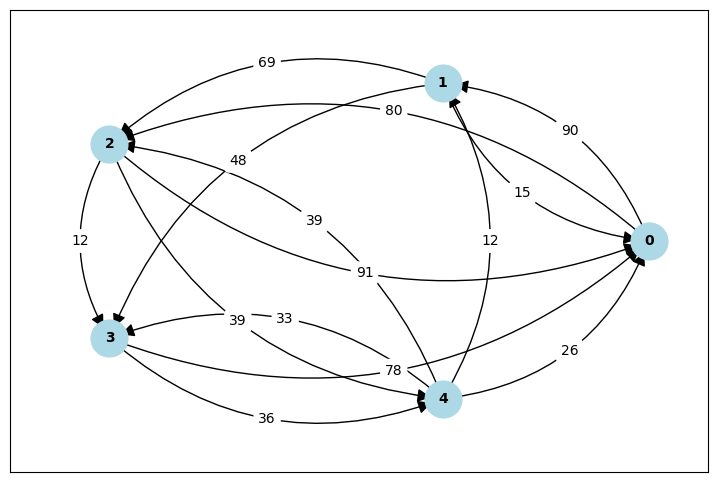

In [5]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P1\distances5.txt')
plot_graph(edges,directed=True,weighted=True)

In [3]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_Dijkstra.txt" 1



Minimum Cost Matrix using Dijkstra: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using Dijkstra for 5 nodes graph: 1938


In [4]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_BellManFord.txt" 1



Minimum Cost Matrix using BellmanFord: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using BellmanFord for 5 nodes graph: 331


In [5]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_FloydWarshall.txt" 1



Minimum Cost Matrix using FloydWarshall: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using FloydWarshall for 5 nodes graph: 76


Dado que tenemos los archivos para verificar el resultado de las respuestas más grandes, diseñamos una función que realice dicha verificación

Vamos a generar las salidas para cada conjunto de datos

In [6]:
#Solucionamos los problemas con Floyd-Warshall

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\Inputs\P1\distancesDisconnected.txt" "data\Outputs\P1\MinCostSolutionDisconnected_FloydWarshall.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_FloydWarshall.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\Inputs\P1\distances100.txt" "data\Outputs\P1\MinCostSolution100_FloydWarshall.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\Inputs\P1\distances1000.txt" "data\Outputs\P1\MinCostSolution1000_FloydWarshall.txt" 0

Execution time in microseconds using FloydWarshall for 4 nodes graph: 107
Execution time in microseconds using FloydWarshall for 5 nodes graph: 85
Execution time in microseconds using FloydWarshall for 100 nodes graph: 16095
Execution time in microseconds using FloydWarshall for 1000 nodes graph: 4766975


In [7]:
#Solucionamos los problemas con Dijkstra

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\Inputs\P1\distancesDisconnected.txt" "data\Outputs\P1\MinCostSolutionDisconnected_Dijkstra.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_Dijkstra.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\Inputs\P1\distances100.txt" "data\Outputs\P1\MinCostSolution100_Dijkstra.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\Inputs\P1\distances1000.txt" "data\Outputs\P1\MinCostSolution1000_Dijkstra.txt" 0

Execution time in microseconds using Dijkstra for 4 nodes graph: 1578
Execution time in microseconds using Dijkstra for 5 nodes graph: 1857
Execution time in microseconds using Dijkstra for 100 nodes graph: 73159
Execution time in microseconds using Dijkstra for 1000 nodes graph: 72811240


In [8]:
#Solucionamos los problemas con BellmanFord

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\Inputs\P1\distancesDisconnected.txt" "data\Outputs\P1\MinCostSolutionDisconnected_BellmanFord.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\Inputs\P1\distances5.txt" "data\Outputs\P1\MinCostSolution5_BellmanFord.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\Inputs\P1\distances100.txt" "data\Outputs\P1\MinCostSolution100_BellmanFord.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\Inputs\P1\distances1000.txt" "data\Outputs\P1\MinCostSolution1000_BellmanFord.txt" 0

Execution time in microseconds using BellmanFord for 4 nodes graph: 142
Execution time in microseconds using BellmanFord for 5 nodes graph: 481
Execution time in microseconds using BellmanFord for 100 nodes graph: 1612801
Execution time in microseconds using BellmanFord for 1000 nodes graph: 17305513986


Verificamos que las soluciones sean correctas cruzando los resultados de los tres metodos

In [9]:
#Checking Solutions for distance100

path = 'Java Projects\GraphsImplementations\data\Outputs\P1'
check_matrices_identical(path+'\MinCostSolution100_Dijkstra.txt',path+'\MinCostSolution100_FloydWarshall.txt')
check_matrices_identical(path+'\MinCostSolution100_Dijkstra.txt',path+'\MinCostSolution100_BellmanFord.txt')
check_matrices_identical(path+'\MinCostSolution100_FloydWarshall.txt',path+'\MinCostSolution100_BellmanFord.txt')

Matrices are equal
Matrices are equal
Matrices are equal


In [10]:
#Checking Solutions for distance1000

path = 'Java Projects\GraphsImplementations\data\Outputs\P1'
check_matrices_identical(path+'\MinCostSolution1000_Dijkstra.txt',path+'\MinCostSolution1000_FloydWarshall.txt')
check_matrices_identical(path+'\MinCostSolution1000_Dijkstra.txt',path+'\MinCostSolution1000_BellmanFord.txt')
check_matrices_identical(path+'\MinCostSolution1000_FloydWarshall.txt',path+'\MinCostSolution1000_BellmanFord.txt')

Matrices are equal
Matrices are equal
Matrices are equal


In [11]:
#Checking Solutions for distance5

path = 'Java Projects\GraphsImplementations\data\Outputs\P1'
check_matrices_identical(path+'\MinCostSolution5_Dijkstra.txt',path+'\MinCostSolution5_FloydWarshall.txt')
check_matrices_identical(path+'\MinCostSolution5_Dijkstra.txt',path+'\MinCostSolution5_BellmanFord.txt')
check_matrices_identical(path+'\MinCostSolution5_FloydWarshall.txt',path+'\MinCostSolution5_BellmanFord.txt')

Matrices are equal
Matrices are equal
Matrices are equal


In [12]:
#Checking Solutions for distanceDisconnected

path = 'Java Projects\GraphsImplementations\data\Outputs\P1'
check_matrices_identical(path+'\MinCostSolutionDisconnected_Dijkstra.txt',path+'\MinCostSolutionDisconnected_FloydWarshall.txt')
check_matrices_identical(path+'\MinCostSolutionDisconnected_Dijkstra.txt',path+'\MinCostSolutionDisconnected_BellmanFord.txt')
check_matrices_identical(path+'\MinCostSolutionDisconnected_FloydWarshall.txt',path+'\MinCostSolutionDisconnected_BellmanFord.txt')

Matrices are equal
Matrices are equal
Matrices are equal


De ese modo, podemos organizar los tiempos de ejecución en microsegundos ($\mu s$) en la siguiente tabla:

| **Entrada** | **Floyd-Warshall** | **BellmanFord** | **Dijkstra** |
|-|-|-|-|
| distanceDisconnected | 107 | 142 | 1578 |
| distance5 | 85 | 481 | 1857 |
| distance100 | 16095 | 1612801 | 73159 |
| distance1000 | 4766975 | 17305513986 | 72811240 |

Lo cual es equivalente a la tabla siguiente en formato de horas, minutos y segundos:

| **Entrada**           | **Floyd-Warshall**   | **BellmanFord**      | **Dijkstra**         |
|-----------------------|----------------------|----------------------|----------------------|
| distanceDisconnected   | 00:00:00.000107 | 00:00:00.000142 | 00:00:00.001578 |
| distance5              | 00:00:00.000085 | 00:00:00.000481 | 00:00:00.001857 |
| distance100            | 00:00:00.016095 | 00:00:01.612801 | 00:00:00.073159 |
| distance1000           | 00:00:04.766975 | 04:48:25.513986 | 00:01:12.811240 |






## Parte 2. Componentes Conectados

Para la solución de este segundo problema, se definió la siguiente estructura para el algoritmo:

**1. Entradas y Salidas**

| E/S | Nombre | tipo | Descripción |
|-|-|-|-|
| E | G | **List** of **tuples** | Lista que contiene las relaciones entre nodos, se encuentra como dos números separados que describen el nodo de salida y el nodo destino|
| S | m | **List** of **List** of **int**| Componentes disyuntos del grafo ingresado |

**2. Tipo de grafo**

Para el problema en cuestión, se definió un grafo no dirigido sin costos.

**3. Estrategias de solución**

Para este problema, se implemementó la solución usando BFS. La idea es qque partiendo de un nodo en particular, es posible conocer todos sus componentes con una ejecución de BFS. Se ejecutará el algoritmo tantas veces como componentes existan en el grafo

En el proyecto adjunto, se realizó una implmentación de BFS para determinar los componentes conectados de un grafo. Se utilizará como principal ejemplo el siguiente grafo:

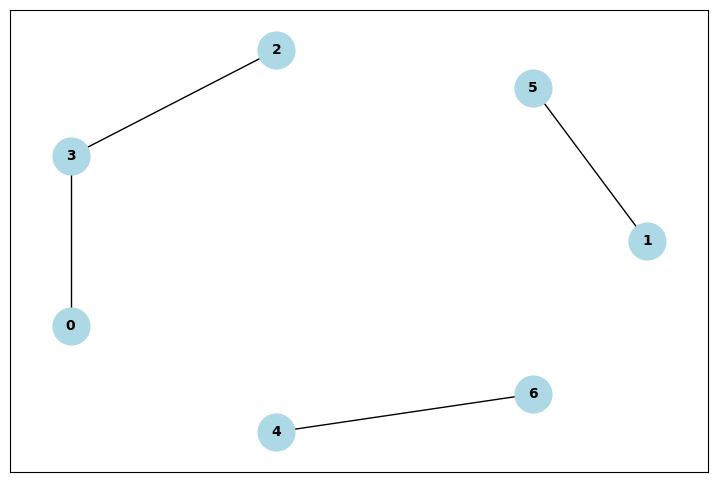

In [13]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P2\componentsExample.txt')
plot_graph(edges,directed=False,weighted=False)

In [14]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\Inputs\P2\componentsExample.txt" "data\Outputs\P2\SolutionExample.txt" 1


Components found using BFS: {{0,3,2},{1,5},{4,6}} 

Execution time in microseconds using BFS for 7 nodes graph: 602


Con el fin de validar visualmente el algoritmo, se buscará implementar con dos grafos adicionales. Uno conexo y uno donde cada eje esta conectado unica y exclusivamente a si mismo.

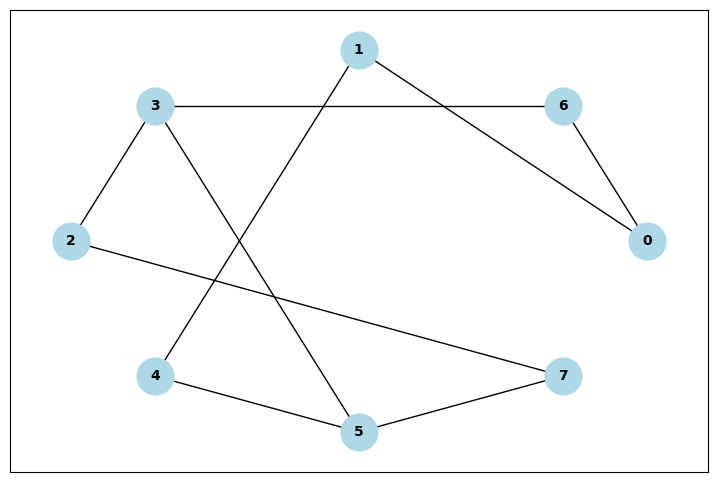

In [15]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P2\componentsConnected.txt')
plot_graph(edges,directed=False,weighted=False)

In [16]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\Inputs\P2\componentsConnected.txt" "data\Outputs\P2\SolutionConnected.txt" 1


Components found using BFS: {{0,6,1,3,4,2,5,7}} 

Execution time in microseconds using BFS for 8 nodes graph: 526


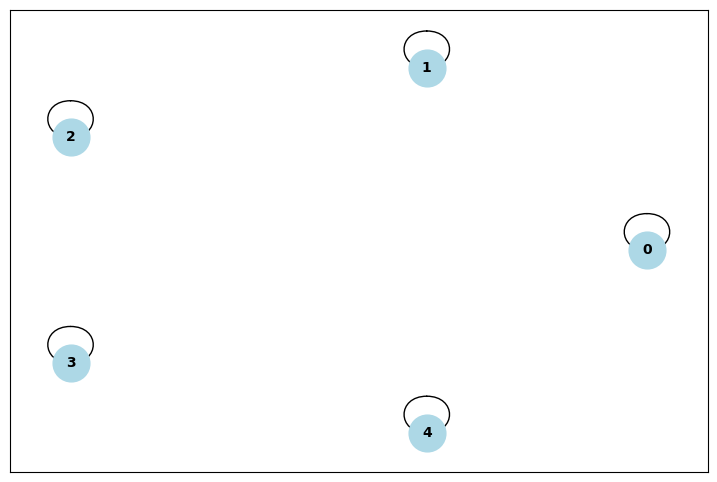

In [17]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P2\componentsIsolated.txt')
plot_graph(edges,directed=False,weighted=False)

In [18]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\Inputs\P2\componentsIsolated.txt" "data\Inputs\P2\SolutionIsolated.txt" 1


Components found using BFS: {{0},{1},{2},{3},{4}} 

Execution time in microseconds using BFS for 5 nodes graph: 458


## Parte 3. Problema de la ciudad y costos viales

Una ciudad se diseño de tal modo que todas sus calles fueran de una
sola vía. Con el paso del tiempo la cantidad de habitantes de la ciudad creció y
esto produjo grandes trancones en algunas de las vias debido a algunos desvíos
innecesarios que tienen que tomar los habitantes de la ciudad para poder llegar
a sus trabajos. Por lo tanto, el alcalde tomó la decisión de ampliar algunas vias
para que puedan convertirse en doble via. Dado el mapa de la ciudad y el costo
de convertir cada via actual en doble via, determinar qué vias se deben
convertir, de modo que se pueda transitar de cualquier punto a cualquier punto
de la ciudad por dobles vias y que el costo de la conversión sea el mínimo
posible.

Para la solución de este tercer problema, se definió la siguiente estructura para el algoritmo:

**1. Entradas y Salidas**

| E/S | Nombre | tipo | Descripción |
|-|-|-|-|
| E | G | **List** of **tuples** of **int** | Lista que contiene el costo de ampliar una via que une un punto A y B de la ciudad, descrito como (A,B,costo)|
| S | R | **List** of **tuples** | Lista de vías que deben ser ampliadas de tal forma que el costo sea mínimo |

**2. Tipo de grafo**

Para el problema en cuestión, se definió un grafo no dirigido conexo con costo positivo en cada eje. Esta estructura se definió con los siguientes criterios:

* **Vértices**: Representan los puntos de la ciudad que unen las vías. Se pueden entender como las intersecciones entre las mismas.

* **Aristas**: Representan la existencia de una vía que une dos puntos de la ciudad.

* **Costos de las aristas**: Las aristas contarán con costos positivos que representarán el valor de convertir dicha vía en doble vía.

* **Conectividad**: El grafo, dado el contexto del problema, debe ser conexo, ya que al reprsentar las vías de una ciudad, podemos decir que de cualquier punto de la ciudad se debe poder llegar a otro.

* **Dirigido o no dirigido**: Dado el contexto del problema, se definió que el grafo fuese no dirigido ya que la única información que nos interesa represntar es la existencia de vías y no la dirección a la que apunta.

**3. Estrategias de solución**

Para este problema, nos interesa definir que vías deben convertirse en doble vía para poder conectar todos los puntos de la ciudad con un costo mínimo. Esto es equivalente a encontrar un conjunto de aristas que recubran todos los vértices del grafo minimizando el costo, o en otras palabras, estamos frente al problema del árbol mínimo recubrimiento (MST).

Por consiguiente, para afrontar este problema, se utilizará el algoritmo de Kruskal

Vamos a tomar los siguientes grafos de ejemplo:

1. Grafo de 7 nodos

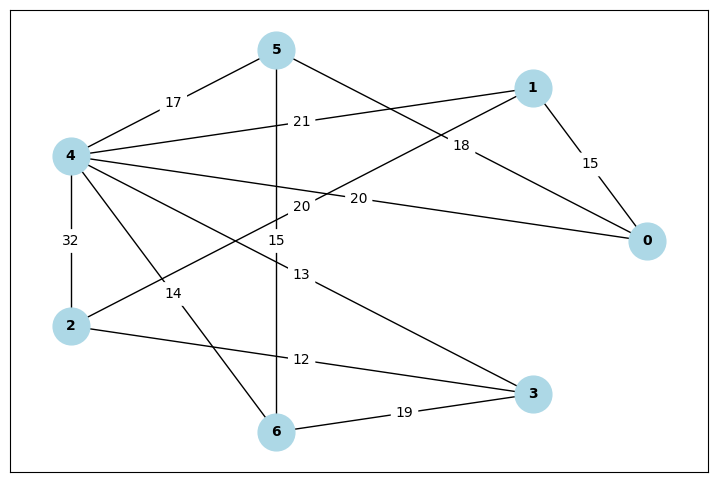

In [19]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P3\ProblemsCity7.txt')
plot_graph(edges,directed=False,weighted=True)

In [20]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations problems CityCosts "data\Inputs\P3\ProblemsCity7.txt" "data\Outputs\P3\SolutionsCity7.txt" 1


Edges from MST: {(2,3),(4,3),(4,6),(0,1),(5,6),(0,5)} 
The minimum cost associated is: 87

Execution time in microseconds using CityCosts for 7 nodes graph: 1585


Vamos a visualizar el arbol de recubrimiento resultante, que es equivalente a las vías que deben transformarse en doble vía

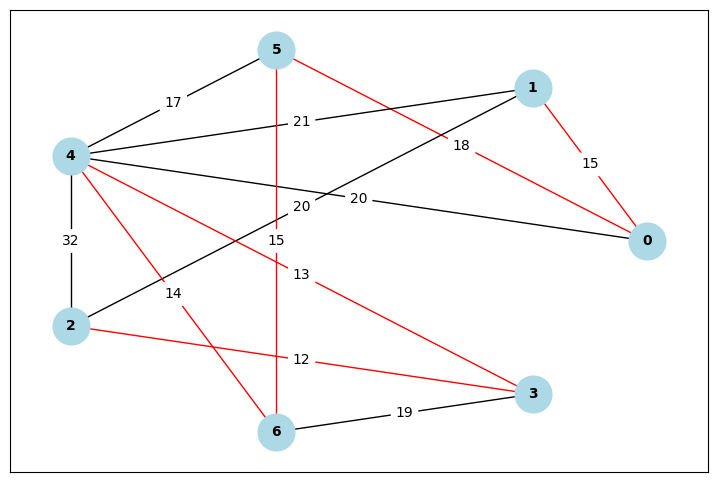

In [21]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P3\ProblemsCity7.txt')
mst = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Outputs\P3\SolutionsCity7.txt')
plot_graph(edges,directed=False,weighted=True,mst = mst)

2. Grafo de 5 nodos

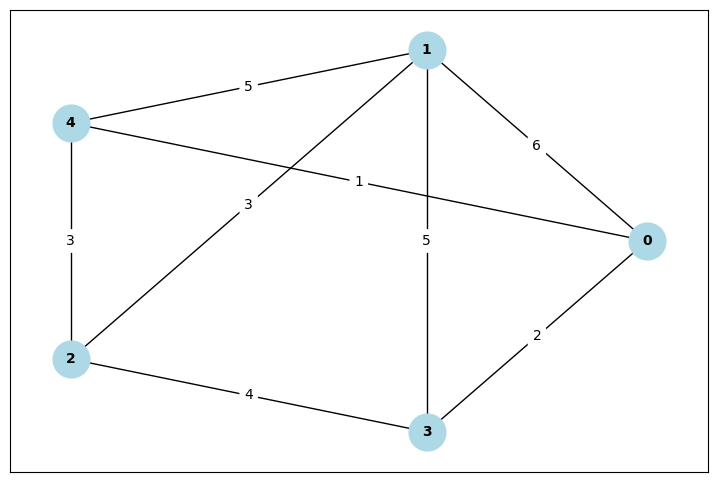

In [22]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P3\ProblemsCity5.txt')
plot_graph(edges,directed=False,weighted=True)

In [23]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations problems CityCosts "data\Inputs\P3\ProblemsCity5.txt" "data\Outputs\P3\SolutionsCity5.txt" 1


Edges from MST: {(0,4),(0,3),(2,4),(1,2)} 
The minimum cost associated is: 9

Execution time in microseconds using CityCosts for 5 nodes graph: 1300


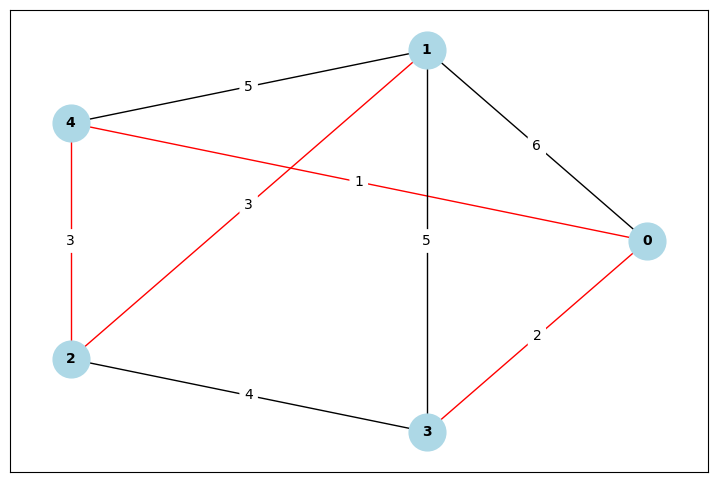

In [24]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Inputs\P3\ProblemsCity5.txt')
mst = read_edge_list_from_file('Java Projects\GraphsImplementations\data\Outputs\P3\SolutionsCity5.txt')
plot_graph(edges,directed=False,weighted=True,mst = mst)

## Parte 4. Problema de la distribución de libros

Una empresa de venta de libros tiene una serie de fábricas en las
que ensambla los libros para vender a diferentes librerias. También cuenta con
una serie de camiones para hacer la distribución. De cada camión se conoce la
cantidad máxima de libros que puede transportar. Finalmente, la empresa
cuenta con unas bodegas para guardar temporalmente libros. Cada bodega
tiene una cantidad máxima de libros que puede guardar, pero tiene como
restricción que no se pueden dejar libros de un dia para otro. Para facilitar la
organización de las rutas, cada camión hace un solo viaje diario y cubre una
sola ruta, ya sea desde una fábrica hasta una librería, desde una fábrica hasta
una bodega o desde una bodega hasta una librería. Dados los puntos de inicio y
llegada de cada camión y las cantidades máximas de libros que puede
almacenar cada camión y cada bodega, determinar cuantos libros se pueden
transportar como máximo en un dia desde las fábricas hasta las librerías.

Para la solución de este cuarto problema, se definió la siguiente estructura para el algoritmo:

**1. Entradas y Salidas**

| E/S | Nombre | tipo | Descripción |
|-|-|-|-|
| E | C | **List** of **tuples** of **String** | Lista que contiene el nombre de la bodega y su capacidad máxima|
| E | R | **List** of **tuples** of **String** | Lista de información con los buses. Contiene tres datos importantes para cada bus; punto de origen, punto de destino y capacidad máxima de libros que puede llevar  |
| S | F | **List** of **tuples** of **String** | Lista de información con los buses. Contiene tres datos importantes para cada bus; punto de origen, punto de destino y cantidad máxima de libros que puede llevar de acuerdo a las restricciones del problema  |
| S | m | **int** | Cantidad máxima de libros que se pueden transportar desde las fabricas hasta las librerias  |

**2. Tipo de grafo**

Para el problema en cuestión, se definió un grafo dirigido con costo positivo en cada eje y ejes antiparalelos. Esta estructura se definió con los siguientes criterios:

* **Vértices**: Representan los puntos de interés para la empresa. En este contexto, pueden representar una bodega, una fabrica o una librería. Las bodegas se trataran como dos nodos (Uno de entrada y uno de salida) para poder tratar su capacidad maxima como un flujo.

* **Aristas**: Representan las rutas que deben realizar los camiones o la capacidad de una bodega. A partir del problema sabemos que estas rutas deben ir exclusivamente de fabrica a libreria, de fabrica a bodega y de bodega a libreria (Denotando que no se pueden presentar ejes antiparalelos). Para cada bodega, existirá una arista que conecta los nodos de entrada y de salida de estos mismos. Con esto en mente, se puede visualizar que el grafo resultante será multipartito, aunque es un resultado interesante, no afecta el enfoque de solución del problema.

* **Costos de las aristas**: Las aristas contarán con costos positivos que representarán la capacidad máxima de cada camión o la capacidad máxima de la bodega dependiendo de los nodos que este conectando.

* **Dirigido o no dirigido**: Dado el contexto del problema, se definió que el grafo fuese dirigido ya que es importante determinar el origen y destino de cada uno de los buses.

**3. Estrategias de solución**

Para este problema, nos interesa conocer la cantidad máxima de libros que se pueden transportar en un día. Esto nos permite visualizar que estamos bajo un problema de optimización en el que estamos restringidos a las capacidades máximas de las bodegas y los buses. Esto convierte al problema y al planteamiento del grafo realizado en candidatos a ser un ejemplo de búsqueda de flujo máximo.

Bajo esa idea, los nodos asociados a las fabricas funcionarán como fuentes, y los nodos asociados a las librerias funcionarán como sumideros; mientras que los nodos asociados a las bodegas funcionarán como nodos intermedios. Dado esto, como en el contexto se pueden tener multiples fabricas y librerias, se incluyen de manera adicional una superfuente y un supersumidero con capacidades infinitas.

En los ejemplos mostrados a continuación, se ve como se manejo esta estructura y como fue útil para el tratamiendo del problema

Se manejarán dos ejemplos que cumplen con las caractersticas descritas para las entradas

**Ejemplo 1**

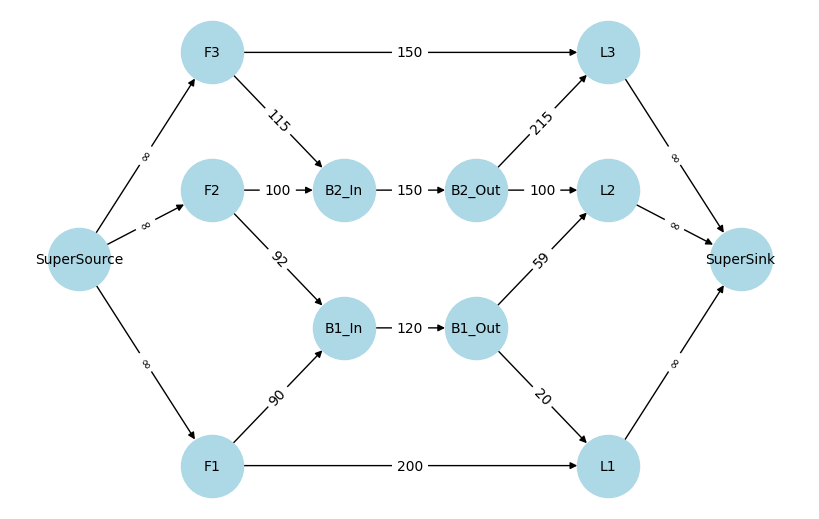

In [25]:
fileCapacities = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example1_VaultCapacities.txt'
fileBuses = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example1_BusesInformation.txt'
_ , edges, sets = getInputProblem(fileCapacities, fileBuses, inf = '$\infty$')
drawBooksProblem(sets, edges,figsize=(8,5))

In [1]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations problems BooksDelivery "data\Inputs\P4\Example1_VaultCapacities.txt" "data\Inputs\P4\Example1_BusesInformation.txt" "data\Outputs\P4\SolutionExample1.txt" 1

Nodes names array size: 12
The maximum amount of books that can be transported is: 579
Execution time in microseconds using BooksDelivery for 12 nodes graph: 7268


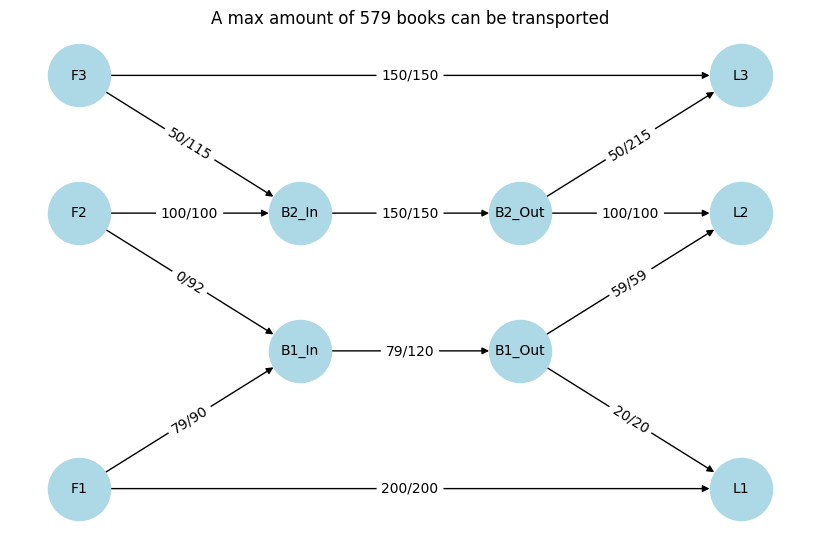

In [27]:
fileCapacities = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example1_VaultCapacities.txt'
fileBuses = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example1_BusesInformation.txt'
fileAnswer = 'Java Projects\GraphsImplementations\data\Outputs\P4\SolutionExample1.txt'
edges, sets , maxFlow = getAnswer(fileCapacities, fileBuses,fileAnswer, inf = '$\infty$')
drawBooksProblem(sets, edges,figsize=(8,5),maxFlow=maxFlow)

**Ejemplo 2**

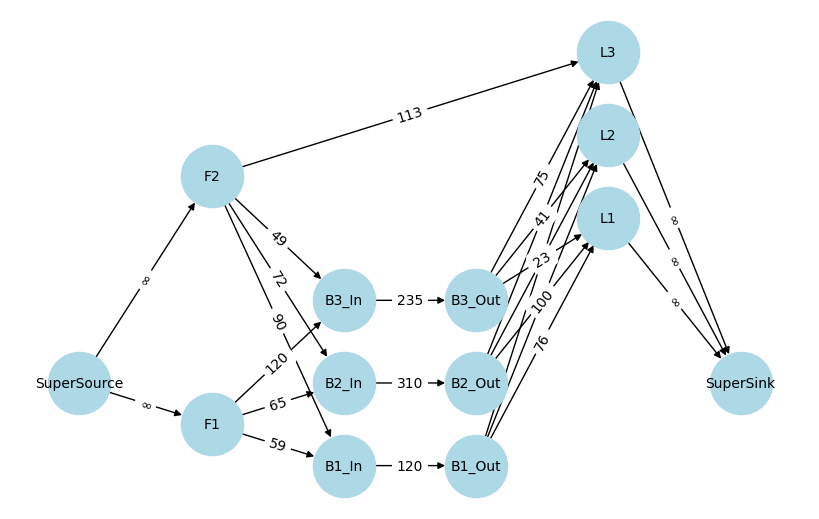

In [28]:
fileCapacities = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example2_VaultCapacities.txt'
fileBuses = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example2_BusesInformation.txt'
_ , edges, sets = getInputProblem(fileCapacities, fileBuses, inf = '$\infty$')
drawBooksProblem(sets, edges,figsize=(8,5))

In [2]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations problems BooksDelivery "data\Inputs\P4\Example2_VaultCapacities.txt" "data\Inputs\P4\Example2_BusesInformation.txt" "data\Outputs\P4\SolutionExample2.txt" 1

Nodes names array size: 13
The maximum amount of books that can be transported is: 509
Execution time in microseconds using BooksDelivery for 13 nodes graph: 8810


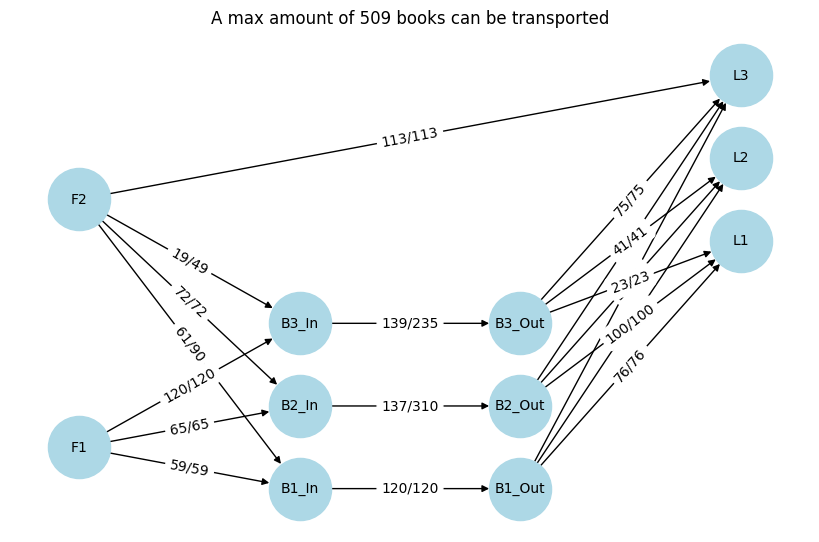

In [30]:
fileCapacities = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example2_VaultCapacities.txt'
fileBuses = 'Java Projects\GraphsImplementations\data\Inputs\P4\Example2_BusesInformation.txt'
fileAnswer = 'Java Projects\GraphsImplementations\data\Outputs\P4\SolutionExample2.txt'
edges, sets , maxFlow = getAnswer(fileCapacities, fileBuses,fileAnswer, inf = '$\infty$')
drawBooksProblem(sets, edges,figsize=(8,5),maxFlow=maxFlow)